In [2]:
import os, json, warnings
from pathlib import Path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree


# CSV_PATH = "synthetic_creditcard_jumbled.csv"
# df = pd.read_csv(CSV_PATH)
# print("Loaded:", CSV_PATH, "shape:", df.shape)
# display(df.head())



In [3]:
# Config
CSV_PATH = "synthetic_creditcard_jumbled.csv"  
OUT_DIR = Path("figure_runs")
OUT_DIR.mkdir(exist_ok=True)
RANDOM_STATE = 42
warnings.filterwarnings("ignore")   

In [4]:
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "shape:", df.shape)
display(df.head())


if "Class" in df.columns:
    target_col = "Class"
else:
    candidates = [c for c in df.columns if c.lower() in ("class", "label", "fraud")]
    if not candidates:
        raise SystemExit("No label column 'Class' or similar found.")
    target_col = candidates[0]

print("Target:", target_col)
print("Fraud count / rate:", int(df[target_col].sum()), "/", df[target_col].mean())


Loaded: synthetic_creditcard_jumbled.csv shape: (10000, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Time,Amount,Class
0,-0.448298,0.386404,0.474918,1.677098,-0.872627,1.235923,-0.565725,-1.554961,-1.007891,0.109200,...,0.616984,0.254443,-0.028294,-2.292657,0.741195,-0.389627,-1.045291,18381.561943,374.998636,0
1,-0.651815,-0.369660,0.390781,0.340452,-1.363479,0.690939,-0.003661,0.938594,0.316083,0.386353,...,1.169489,0.906023,-1.749479,0.594052,0.883898,0.342658,0.481750,117822.512033,260.901396,0
2,0.495033,0.086693,1.009339,-0.785789,-0.224465,0.114147,-1.433821,-1.805550,-0.020799,1.337637,...,0.729269,0.347885,-0.072240,-0.420422,-0.609215,3.065526,-1.541048,10374.487493,153.373164,0
3,0.963416,1.374477,-1.362334,0.115145,-1.680050,-0.276429,0.120284,0.319128,-0.181611,-0.418353,...,0.077909,-0.566076,-0.601145,0.118976,0.051435,0.611621,-0.241415,53790.882088,186.398545,0
4,-3.384669,0.070857,0.060969,0.198196,-2.144057,-0.749768,0.661347,2.306483,0.571553,1.960708,...,-0.472791,-0.561405,-0.451942,-0.477527,1.383869,-1.205733,1.081542,13329.106142,41.325029,0


Target: Class
Fraud count / rate: 146 / 0.0146


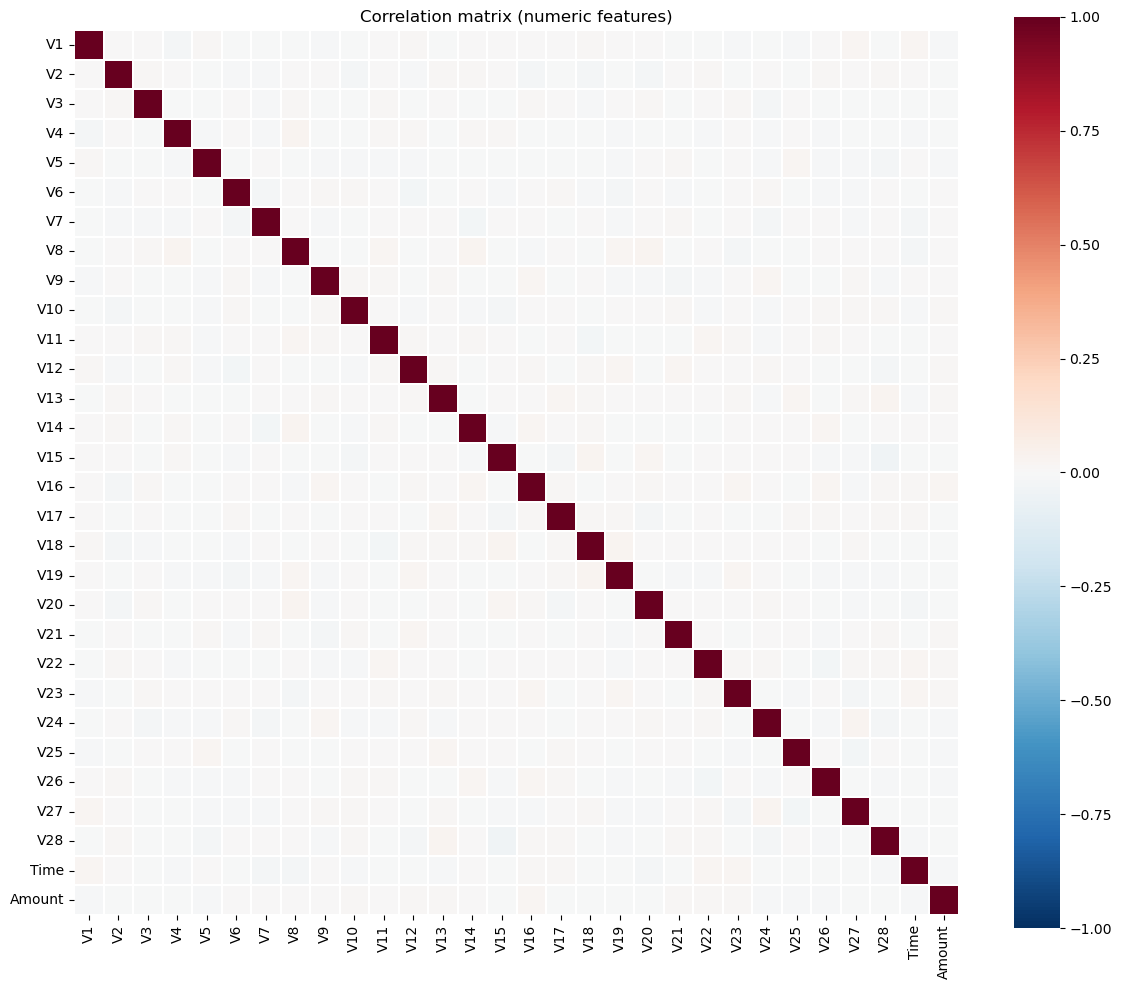

<Figure size 640x480 with 0 Axes>

In [5]:
# compute correlation for numeric features (limit to first 20 if many for readability)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# exclude target if present
if target_col in num_cols: num_cols.remove(target_col)

corr = df[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="RdBu_r", center=0, vmin=-1, vmax=1, square=True, linewidths=0.2)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

# Save heatmap to file
OUT_DIR.joinpath("correlation_matrix.png").parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_DIR / "correlation_matrix.png", dpi=150, bbox_inches="tight")


In [6]:
# For each feature, compute fraud rate among rows where that feature is "high" or "positive".
# Simpler: compute mean(Class) grouped by binned versions of numeric features, then find features showing highest mean in top bin.
# But a simple and report-friendly approach: compute correlation with target and raw group statistics.

# 1) Correlation with target (Pearson)
corr_with_target = df[num_cols + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)
print("Top 10 features positively correlated with fraud (by Pearson):")
display(corr_with_target.head(10))

print("\nTop 10 features negatively correlated with fraud:")
display(corr_with_target.tail(10))

# 2) Attribute with most fraud (by mean(Class) when feature in top 5%):
def top_bin_fraud_rate(series, df_labels, top_pct=0.05):
    thr = np.nanpercentile(series.dropna(), 100*(1-top_pct))
    mask = series >= thr
    if mask.sum() == 0:
        return np.nan
    return df_labels[mask].mean()

rates = {}
for c in num_cols:
    try:
        rates[c] = top_bin_fraud_rate(df[c], df[target_col], top_pct=0.05)
    except Exception:
        rates[c] = np.nan

rates_s = pd.Series(rates).dropna().sort_values(ascending=False)
print("\nAttributes whose top 5% bin has highest fraud rate:")
display(rates_s.head(10))

print("\nAttributes whose top 5% bin has lowest fraud rate:")
display(rates_s.tail(10))

# Pick single attributes for report
attr_most_fraud = rates_s.idxmax()
attr_least_fraud = rates_s.idxmin()
print(f"\nAttribute with most fraud (top-5%): {attr_most_fraud}")
print(f"Attribute with least fraud (top-5%): {attr_least_fraud}")

# Save these to a small JSON for inclusion in the report
OUT_DIR.joinpath("data_prep.json").write_text(
    json.dumps({
        "attr_most_fraud": str(attr_most_fraud),
        "attr_least_fraud": str(attr_least_fraud),
        "fraud_rate_overall": float(df[target_col].mean())
    }, indent=2)
)


Top 10 features positively correlated with fraud (by Pearson):


V27       0.018343
V17       0.011375
V4        0.008691
V9        0.005268
V23       0.004638
V11       0.003144
V21       0.002795
Amount    0.002601
V16       0.002323
V22       0.001720
Name: Class, dtype: float64


Top 10 features negatively correlated with fraud:


V7    -0.006860
V15   -0.007080
V8    -0.007652
V13   -0.008279
V24   -0.009205
V2    -0.009224
V14   -0.010571
V5    -0.016794
V19   -0.024421
V18   -0.026378
Name: Class, dtype: float64


Attributes whose top 5% bin has highest fraud rate:


V10     0.024
V27     0.022
V23     0.022
V28     0.020
V11     0.020
V9      0.018
V16     0.018
Time    0.018
V17     0.016
V21     0.016
dtype: float64


Attributes whose top 5% bin has lowest fraud rate:


V12    0.014
V13    0.014
V6     0.012
V2     0.012
V8     0.012
V14    0.012
V7     0.010
V4     0.010
V19    0.010
V15    0.006
dtype: float64


Attribute with most fraud (top-5%): V10
Attribute with least fraud (top-5%): V15


91

In [7]:
# Optional small feature: hour-of-day from Time if present
if "Time" in df.columns:
    # original Kaggle Time is seconds since first transaction
    df["Hour"] = ((df["Time"] % 86400) // 3600).astype(int)

# Re-define numeric columns now (drop target)
X = df.drop(columns=[target_col]).copy()
y = df[target_col].astype(int).values

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns to scale:", numeric_cols[:20], " (count:", len(numeric_cols), ")")

preprocessor = ColumnTransformer(
    [("num", StandardScaler(), make_column_selector(dtype_include=np.number))],
    remainder="drop"
)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape, "Train fraud rate:", y_train.mean())


Numeric columns to scale: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']  (count: 31 )
Train shape: (8000, 31) Test shape: (2000, 31) Train fraud rate: 0.014625


In [10]:
def pick_threshold_by_pr(y_true, scores):
    p, r, t = precision_recall_curve(y_true, scores)
    t = np.append(t, 1.0)
    f1s = (2 * p * r) / (p + r + 1e-12)
    idx = int(np.nanargmax(f1s))
    return float(t[idx]), float(f1s[idx])

def metrics_for_model(y_true, scores, threshold="auto"):
    roc = float(roc_auc_score(y_true, scores))
    pr = float(average_precision_score(y_true, scores))
    if threshold == "auto":
        thr, f1_at_thr = pick_threshold_by_pr(y_true, scores)
    else:
        thr = float(threshold)
        preds = (scores >= thr).astype(int)
        f1_at_thr = float(f1_score(y_true, preds))
    preds = (scores >= thr).astype(int)
    prec = float(precision_score(y_true, preds, zero_division=0))
    rec = float(recall_score(y_true, preds, zero_division=0))
    cm = confusion_matrix(y_true, preds).tolist()
    return {
        "roc_auc": roc, "pr_auc": pr, "threshold": thr, "f1": f1_at_thr,
        "precision": prec, "recall": rec, "confusion_matrix": cm
    }

def print_and_plot(name, y_true, scores):
    rep = metrics_for_model(y_true, scores, threshold="auto")
    print(f"=== {name} ===")
    print(f"ROC-AUC: {rep['roc_auc']:.4f}  PR-AUC: {rep['pr_auc']:.4f}")
    print(f"Threshold selected (PR-F1): {rep['threshold']:.4f}")
    print(f"Precision: {rep['precision']:.4f}  Recall: {rep['recall']:.4f}  F1: {rep['f1']:.4f}")
    print("Confusion matrix [TN, FP], [FN, TP]:\n", np.array(rep["confusion_matrix"]))
    # PR curve
    p, r, _ = precision_recall_curve(y_true, scores)
    plt.figure(figsize=(6,4))
    plt.plot(r, p)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{name} — Precision-Recall")
    plt.grid(True); plt.show()
    return rep


=== Naïve Bayes (GaussianNB) ===
ROC-AUC: 0.5040  PR-AUC: 0.0191
Threshold selected (PR-F1): 0.0301
Precision: 0.0342  Recall: 0.1724  F1: 0.0571
Confusion matrix [TN, FP], [FN, TP]:
 [[1830  141]
 [  24    5]]


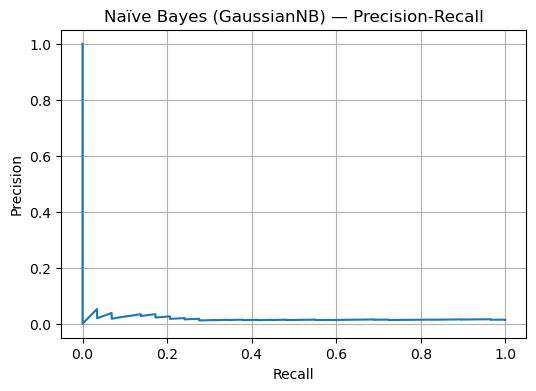

296

In [11]:
# Pipeline: scaler + NB
pipe_nb = Pipeline([("pre", preprocessor), ("model", GaussianNB())])
pipe_nb.fit(X_train, y_train)
# For GaussianNB, predict_proba is available
scores_nb = pipe_nb.predict_proba(X_test)[:,1]
rep_nb = print_and_plot("Naïve Bayes (GaussianNB)", y_test, scores_nb)
# Save
(OUT_DIR / "naive_bayes").mkdir(exist_ok=True)
(OUT_DIR / "naive_bayes" / "report.json").write_text(json.dumps(rep_nb, indent=2))


=== Logistic Regression ===
ROC-AUC: 0.5729  PR-AUC: 0.0176
Threshold selected (PR-F1): 0.6248
Precision: 0.0208  Recall: 0.6552  F1: 0.0404
Confusion matrix [TN, FP], [FN, TP]:
 [[1078  893]
 [  10   19]]


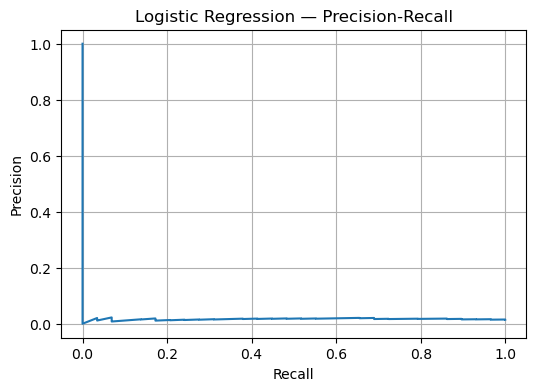

297

In [13]:
# Use robust solver and higher max_iter to avoid convergence warnings
lr = LogisticRegression(solver="saga", penalty="l2", C=1.0, class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE)
pipe_lr = Pipeline([("pre", preprocessor), ("model", lr)])
pipe_lr.fit(X_train, y_train)
scores_lr = pipe_lr.predict_proba(X_test)[:,1]
rep_lr = print_and_plot("Logistic Regression", y_test, scores_lr)
(OUT_DIR / "logistic_regression").mkdir(exist_ok=True)
(OUT_DIR / "logistic_regression" / "report.json").write_text(json.dumps(rep_lr, indent=2))


SVM training on subset: (5000, 31)
=== Support Vector Machine (RBF) ===
ROC-AUC: 0.5291  PR-AUC: 0.0186
Threshold selected (PR-F1): 0.0168
Precision: 0.0909  Recall: 0.0345  F1: 0.0500
Confusion matrix [TN, FP], [FN, TP]:
 [[1961   10]
 [  28    1]]


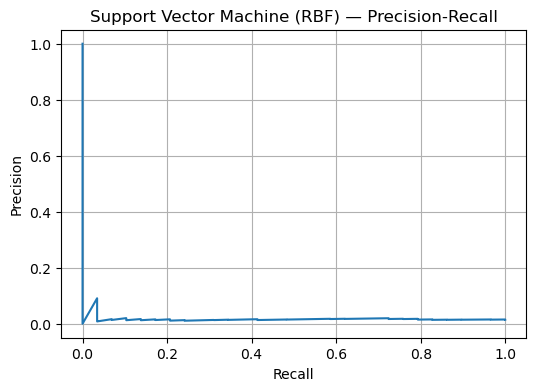

298

In [14]:
# SVM probability=True can be slow on large datasets. If needed, cap training subset.
max_svm_train = 5000
Xtr = X_train; ytr = y_train
if len(X_train) > max_svm_train:
    idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train), size=max_svm_train, replace=False)
    Xtr = X_train.iloc[idx]
    ytr = y_train[idx]
    print("SVM training on subset:", Xtr.shape)

# Build pipeline manually since we may use subset of training rows
scaler = preprocessor.named_transformers_["num"].fit(X_train.select_dtypes(include=[np.number]))
Xtr_scaled = preprocessor.transform(Xtr)
Xtest_scaled = preprocessor.transform(X_test)

svm = SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE)
svm.fit(Xtr_scaled, ytr)
scores_svm = svm.predict_proba(Xtest_scaled)[:,1]
rep_svm = print_and_plot("Support Vector Machine (RBF)", y_test, scores_svm)
(OUT_DIR / "svm_rbf").mkdir(exist_ok=True)
(OUT_DIR / "svm_rbf" / "report.json").write_text(json.dumps(rep_svm, indent=2))


=== Decision Tree Classifier ===
ROC-AUC: 0.4308  PR-AUC: 0.0149
Threshold selected (PR-F1): 0.9440
Precision: 0.0370  Recall: 0.0345  F1: 0.0357
Confusion matrix [TN, FP], [FN, TP]:
 [[1945   26]
 [  28    1]]


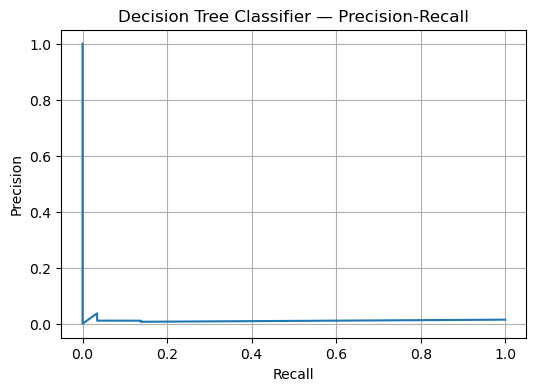

✅ Decision Tree evaluation complete and report saved.


In [56]:
# 4.3.5 Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

# Initialize model
dt = DecisionTreeClassifier(
    criterion="gini",           # or 'entropy'
    max_depth=8,                # prevents overfitting
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

# Create pipeline (same as previous models)
pipe_dt = Pipeline([
    ("pre", preprocessor),
    ("model", dt)
])

# Train the model
pipe_dt.fit(X_train, y_train)

# Predict fraud probabilities
scores_dt = pipe_dt.predict_proba(X_test)[:, 1]

# Evaluate using the same helper function
rep_dt = print_and_plot("Decision Tree Classifier", y_test, scores_dt)

# Save the report to disk
(OUT_DIR / "decision_tree").mkdir(exist_ok=True)
(OUT_DIR / "decision_tree" / "report.json").write_text(json.dumps(rep_dt, indent=2))
print("✅ Decision Tree evaluation complete and report saved.")


In [51]:
model_reports = {
    "Naïve Bayes": rep_nb,
    "Logistic Regression": rep_lr,
    "SVM (RBF Kernel)": rep_svm,
    "Decision Tree": rep_dt
}

# Create summary DataFrame
summary_df = pd.DataFrame(model_reports).T[
    ["roc_auc", "pr_auc", "precision", "recall", "f1"]
].sort_values(by="pr_auc", ascending=False)

# Print summary in a nice table format
print("\n=== Model Performance Summary ===\n")
print(summary_df.round(4).to_string())

# Save as CSV for report inclusion
summary_path = OUT_DIR / "model_performance_summary.csv"
summary_df.to_csv(summary_path, index=True)
print(f"\n✅ Summary metrics saved to: {summary_path.resolve()}")


=== Model Performance Summary ===

                      roc_auc    pr_auc precision    recall        f1
Naïve Bayes           0.50398  0.019118  0.034247  0.172414  0.057143
SVM (RBF Kernel)     0.529068  0.018561  0.090909  0.034483      0.05
Logistic Regression  0.572893  0.017612  0.020833  0.655172  0.040383
Decision Tree        0.430842  0.014895  0.006908  0.137931  0.013158

✅ Summary metrics saved to: C:\Users\karth\figure_runs\model_performance_summary.csv
